In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.dataset.tools.apply_rf import ApplyResponseFunction

In [2]:
# Load up the arf transform
ARF = ApplyResponseFunction("../dorf.json", "../mapping.npy")

# Load in two point clouds
pc1 = np.load("../dublin/npy/1.npy")
pc2 = np.load("../dublin/npy/10.npy")
print(pc1.shape)
print(pc2.shape)

# Apply some alteration to pc2
pc2_alt = ARF(pc2, 10, 512, noise=False)
print(pc2_alt.shape)

(33213636, 9)
(39719186, 9)
(39719186, 9)


In [3]:
# define some distributions
d = [
    pc1[:, 3],
    pc2_alt[:, 3]
]

# optionally apply some noise to the response:
d[1]+=np.random.normal(0, 1., d[1].shape)

print(d[0].shape, d[0].min(), d[0].max())
print(d[1].shape, d[1].min(), d[1].max())

# global mins and maxes
g = np.concatenate(d)
print(g.min(), g.max())

# bins
bin_range = [g.min(), g.max()]
bin_num = int((g.max()-g.min())/5.)

# plot colors
line_colors = ["xkcd:red", "xkcd:blue", "xkcd:green"]
pdf_colors = [(1, 0, 0, .5), (0, 0, 1, .5), (0, 1, 0, .4)]

line_colors = line_colors[:len(d)]
pdf_colors = pdf_colors[:len(d)]

(33213636,) 0.0 512.0
(39719186,) -3.4178240757969194 516.3442405096911
-3.4178240757969194 516.3442405096911


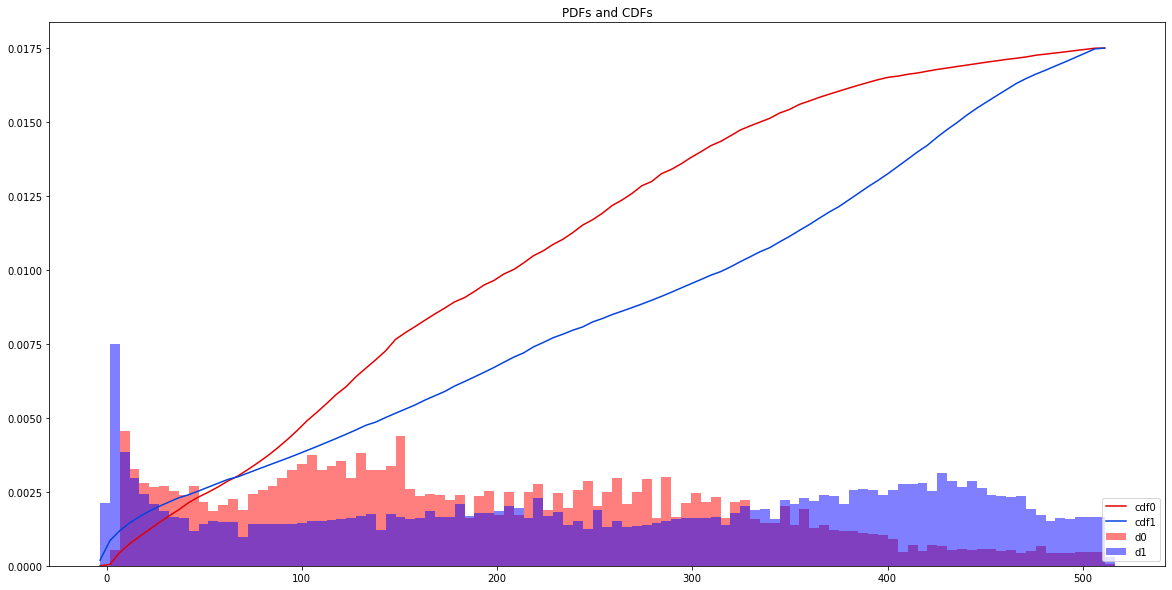

In [4]:
# Show histograms with CDF
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20,10))
histograms = []
for i, data in enumerate(zip(d, pdf_colors, line_colors)):
    d_i, pdf_color, line_color = data
    
    # plot pdf
    hist, bin_edges, _ = ax.hist(d_i, bins=bin_num, range=bin_range, density=True, label=f"d{i}", fc=pdf_color)
    hist = hist/sum(hist)  # use pdf
    histograms.append((hist, bin_edges))
    
    # calculate cdf 
    cdf = np.cumsum(hist)  
    
    # scale factor (so histogram is visible)
    max_height = 0.0175

    # plot cdf
    width = np.diff(bin_edges)
    ax.plot((np.arange(len(cdf))*width)+bin_edges[0], cdf*max_height, line_color, label=f"cdf{i}")
    

ax.legend(loc='lower right')
ax.set_title("PDFs and CDFs")
plt.show()

In [5]:
def histogram_match(target, reference):
    # # # 
    #
    # Params: 
    #    target: distribution as np array
    #    reference: Pdistribution as np array
    #
    # Output: 
    #    "matched" target distribution to reference distribution
    #
    # # #
    
    # global mins and maxes
    g = np.concatenate((target, reference))

    # bins
    bin_range = [g.min(), g.max()]
    bin_num = int((g.max()-g.min())/5.)
    
    # Convert distributions to histograms
    target_hist, target_be = np.histogram(target, bins=bin_num, range=bin_range, density=True)
    reference_hist, reference_be = np.histogram(reference, bins=bin_num, range=bin_range, density=True)
    
    # PDF
    target_hist = target_hist/sum(target_hist)
    reference_hist = reference_hist/sum(reference_hist)
    
    # choose some arbitrary y values (y range: [0, 1])
    y_vals = np.random.uniform(size=10000)

    # sort these as monotonically increasing
    y_vals.sort()
    
    # interpolate x value pairs from the CDFs
    x_reference = np.interp(
        y_vals,
        np.hstack((np.zeros(1), np.cumsum(reference_hist))),
        reference_be)
    
    x_target = np.interp(
        y_vals,
        np.hstack((np.zeros(1), np.cumsum(target_hist))),
        target_be)
    
    # We now have three vectors denoting y-x0-x1 groups. We want to create a mapping
    # that defines the relationship for x0 -> x1 for any x0. 
    m_vals = np.interp(
        np.linspace(g.min(), g.max(), 10000),
        x_target,
        x_reference)
    
    # Interpolate values over the combined distributions
    x = np.arange(g.min(), g.max(), (g.max()-g.min())/10000)

    m = np.interp(target, x, m_vals)
    
    return m

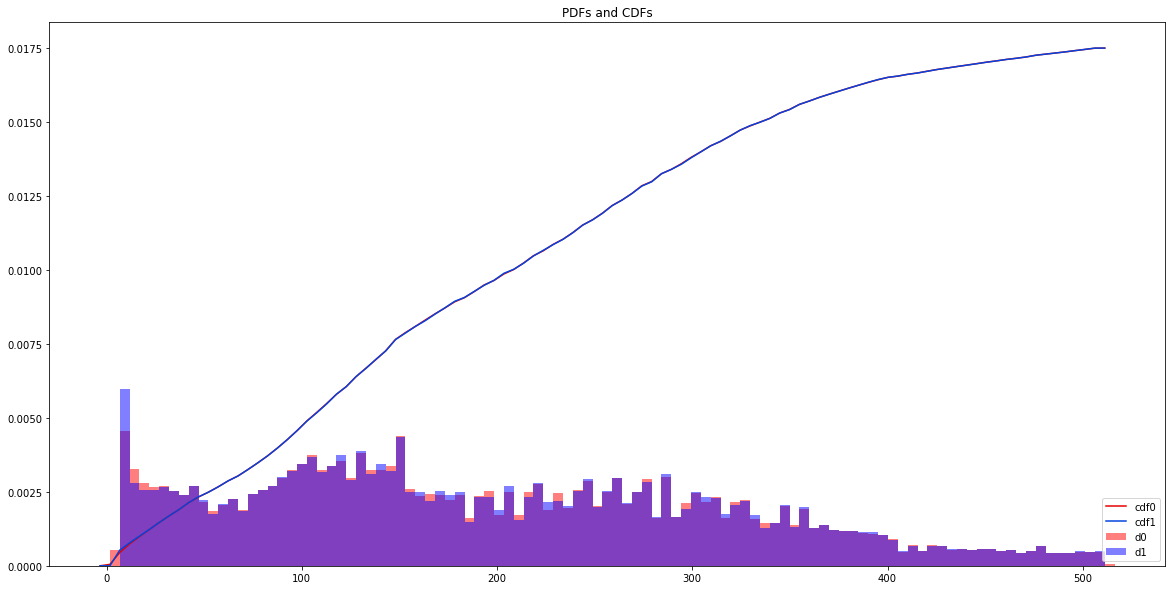

In [6]:
# Put all of this together

fig, ax = plt.subplots(1, figsize=(20,10))

m = histogram_match(d[1], d[0])

# Overwrite the target distribution with the matched distribution
d_new = (d[0], m)

for i, data in enumerate(zip(d_new, pdf_colors, line_colors)):
    d_i, pdf_color, line_color = data
    
    # plot pdf
    hist, bin_edges, _ = ax.hist(d_i, bins=bin_num, range=bin_range, density=True, label=f"d{i}", fc=pdf_color)
    hist = hist/sum(hist)  # use pdf
    
    # calculate cdf 
    cdf = np.cumsum(hist)  

    # plot cdf
    width = np.diff(bin_edges)
    ax.plot((np.arange(len(cdf))*width)+bin_edges[0], cdf*0.0175, line_color, label=f"cdf{i}")
    
ax.set_title("PDFs and CDFs")
ax.legend(loc='lower right')

plt.show()

MAE: 0.003860


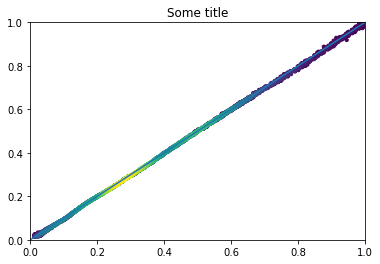

In [7]:
# comparison with original
from scipy.stats import gaussian_kde

sample_size = 5000
sample = np.random.choice(len(m), size=sample_size)
y = m[sample]/512
x = pc2[sample, 3]/512

xy = np.vstack([y, x])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=10)
ax.set_title("Some title")
ax.plot([0, 1], [0, 1])

plt.margins(x=0, y=0)

MAE = np.mean(np.abs(m/512 - pc2[:, 3]/512))
print(f"MAE: {MAE:4f}")

In [8]:
import pptk

# placeholder
my_point = np.array([[3.16476125e+05, 2.34625344e+05, 1.20866585e+01]])

# Get 10000 points from both scans centered on this point
kd1 = pptk.kdtree._build(pc1[:, :3])
kd2 = pptk.kdtree._build(pc2[:, :3])

q1 = pptk.kdtree._query(kd1, my_point, k=1e7)
q2 = pptk.kdtree._query(kd2, my_point, k=1e7)


In [15]:
tile1 = pc1[tuple(q1)]
tile2 = pc2[tuple(q2)]
tile2_alt = pc2_alt[tuple(q2)]
m_s = m[tuple(q2)]

# filter by position 
print(tile1.shape)
print(my_point.shape)
tile1 = tile1[tile1[:, 1] < my_point[0, 1]]
f = tile2[:, 1] >= my_point[0, 1]
tile2 = tile2[f]
tile2_alt = tile2_alt[f]
m_s = m_s[f]


tile = np.concatenate((tile1[:, :3], tile2[:, :3]))
gt_intensity = np.concatenate((tile1[:, 3], tile2[:, 3]))
alt_intensity = np.concatenate((tile1[:, 3], tile2_alt[:, 3]))
fix_intensity = np.concatenate((tile1[:, 3], m_s))
v = pptk.viewer(tile)
v.attributes(gt_intensity, alt_intensity, fix_intensity)

(10000000, 9)
(1, 3)


In [16]:
v.set(show_axis=True)
v.get('lookat')

array([ 3.16500281e+05,  2.34594344e+05, -8.68690033e+01])

In [17]:
v.set(lookat=[3.16474625e+05,  2.34625625e+05, -8.56084442e+01])
v.set(r=300)
v.set(phi=0)
v.set(point_size=0.1)
v.set(theta=1.5217092)
v.set(show_grid=False)
v.set(show_info=False)
v.set(show_axis=False)
v.set(bg_color=(1,1,1,1))

In [18]:
v.set(curr_attribute_id=0)
v.capture("gt_hist_match.png")
v.set(curr_attribute_id=1)
v.capture("alt_hist_match.png")
v.set(curr_attribute_id=2)
v.capture("fix_hist_match.png")

In [19]:
v.close()

![alt text](gt_hist_match.png "gt")
![alt text](alt_hist_match.png "alt")
![alt text](fix_hist_match.png "fix")